# Competition in an oligopolistic market 
## - The Cournot Model

Imports and set magics:

In [22]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from modelproject import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

The model of Cournot competition descibes an industry wherein competing firms offers identical products. The firms complete via the quantity of output they individually produce, simultaneously and autonomously. This model is named after its founder, the French mathematician Augustin Cournot.

First, we will take a look at the most simple case of a duoploy where only two firms are competing the a given market. The model is given as followed:

$$
\begin{aligned}
\Pi_1(Q) & =p(Q)q_1-q_1MC_1 \\
\Pi_2(Q) & =p(Q)q_2-q_2MC_2 \\
\end{aligned}
$$

In the profit functions above, price is determined by the total output denoted as $Q$, where for the two firms, the total output $Q$ equals the sum of their individual outputs $q_1$ and $q_2$. As an illustrative example, let's assume that the price (expressed as the inverse demand function) follows a linear format, represented by $p = a + bQ$ with a indicating the intersection, and b indicating the slope.

Consequently, the inverse demand function can be expressed as $p = a + q_1b + q_2b$. This means, that each firm, when deciding how much to produce and thus the size of their profit, they take the other firms quantity produced into account as it affects the price.

From the functions above, we see, that the firms profit is negatively affected by the marginal costs of producing one of the goods. In this very simple case, we will first look at a case, where $MC_1 = MC_2 = MC$. That is identical and fixed marginal costs.

## Analytical solution

In the initial part of this project we will find an analytical solution to the Cournot model. Although we acknowledge that this aspect of the project may not be particularly crucial, it is nonetheless essential to include. We utilized the SymPy function for this purpose, and the solution is presented below.

**Setting up with SymPy**

Here we now define the parameters we need when defining the functions with SymPy according to the model.

In [23]:
a = sm.symbols('a')
b = sm.symbols('b')
pi_1 = sm.symbols('pi_1')
pi_2 = sm.symbols('pi_2')
mc = sm.symbols('MC')
q1 = sm.symbols('q_1')
q2 = sm.symbols('q_2')
q_star = sm.symbols('q^*')

**Profit functions for each firm**

We now set up the profit functions for each firm using the sm.Eq().


In [24]:
# Profit function for firm 1

profit_1 = sm.Eq(pi_1,(a-b*q1-b*q2-mc)*q1)
profit_1

Eq(pi_1, q_1*(-MC + a - b*q_1 - b*q_2))

In [25]:
# Profit function for firm 1

profit_2 = sm.Eq(pi_2,(a-b*q1-b*q2-mc)*q2)
profit_2

Eq(pi_2, q_2*(-MC + a - b*q_1 - b*q_2))

**FOC for each firm**

We take the first order conditions since we assume, that the firms are profit-maximizing. That is, the firms will produce up to the level, where the $MC = MR$ meaning $MR - MC = 0$, so we can set the FOCs equal to 0, when we later solve for q1 and q2 respectively.

In [26]:
#FOC firm 1
profit_1 = (a-b*q1-b*q2-mc)*q1
foc_q1 = sm.diff(profit_1, q1)
foc_q1_eq0 = sm.Eq(foc_q1,0)
foc_q1_eq0

Eq(-MC + a - 2*b*q_1 - b*q_2, 0)

In [27]:
#FOC firm 2
profit_2 = (a-b*q1-b*q2-mc)*q2
foc_q2 = sm.diff(profit_2, q2)
foc_q2_eq0 = sm.Eq(foc_q2,0)
foc_q2_eq0

Eq(-MC + a - b*q_1 - 2*b*q_2, 0)

**Solving for q1 and q2**

We can now solve for q1 and q2 respectively. That is, we find the quantities each firm will produce given the amount produced by the other firm, their marginal cost, a and b. We refer to these functions as the firms best response functions.

In [28]:
#We solve FOC1 for q1 to obtain best response function for firm 1
solve_q1 = sm.solve(foc_q1,q1)
solve_q1_eq = sm.Eq(q1,solve_q1[0])
solve_q1_eq

Eq(q_1, (-MC + a - b*q_2)/(2*b))

In [29]:
#We solve FOC2 for q2 to obtain best response function for firm 2
solve_q2 = sm.solve(foc_q2,q2)
solve_q2_eq = sm.Eq(q2,solve_q2[0])
solve_q2_eq

Eq(q_2, (-MC + a - b*q_1)/(2*b))

Since the firms have identical marginal costs and price, the relationship between the quantity produced by each firm is symmetrical that is $q1 = q2 = q^*$. 

In [30]:
solve_q1_subs = solve_q1[0].subs(q2,q_star)
solve_q1_subs

(-MC + a - b*q^*)/(2*b)

In [31]:
solve_q2_subs = solve_q2[0].subs(q1,q_star)
solve_q2_subs

(-MC + a - b*q^*)/(2*b)

**Finding the Nash Equilibrium**

In [32]:
# We set up the nash equilibrium equation from inserting q1 = q2 = q* into each of the best response functions
nash_eq = sm.Eq(q_star,solve_q1_subs)
nash_eq

Eq(q^*, (-MC + a - b*q^*)/(2*b))

In [33]:
# We solve for the q*
nash_eq_solve = sm.solve(nash_eq,q_star)
nash_eq_solve[0]

(-MC + a)/(3*b)

Using SymPy, we have derived the best response (BR) functions for both firms and determined the Nash Equilibrium, a quantity of $q^*$ for each, which means that the total quantity in equilibrium is $Q = 2q^*$. Thus we have:

$$
\begin{aligned}
\ BR: q_1 = q_2 = \frac{a - bq^*-MC}{2b} \
\end{aligned}
$$
$$
\begin{aligned}
\ Nash: q^* = \frac{a - MC}{3b} \
\end{aligned}
$$
$$
\begin{aligned}
\ Q = 2q^* = \frac{2(a - MC)}{3b} \
\end{aligned}
$$

**Creating functions using Lamdify**

After utilizing SymPy to derive the solution, we will employ lambdify to convert these  expressions into callable functions. By doing so, we can efficiently evaluate these expressions using specific numerical values, facilitating numerical analysis and computation.

In [34]:
best_resp_q1 = sm.lambdify(args=(a,b,mc),expr=solve_q1[0])
best_resp_q2 = sm.lambdify(args=(a,b,mc),expr=solve_q2[0])
nash_qstar = sm.lambdify(args=(a,b,mc),expr=nash_eq_solve[0])

In [35]:
# we set the parameters and want to vary over marginal costs
a_val = 50
b_val = 3
mc_vec = np.linspace(1,10,10)

nash_eq = nash_qstar(a_val, b_val, mc_vec)

for mc, n in zip(mc_vec, nash_eq):
    print(f'For mc = {mc:1.1f}, we have q* = {n:1.3f}')


For mc = 1.0, we have q* = 5.444
For mc = 2.0, we have q* = 5.333
For mc = 3.0, we have q* = 5.222
For mc = 4.0, we have q* = 5.111
For mc = 5.0, we have q* = 5.000
For mc = 6.0, we have q* = 4.889
For mc = 7.0, we have q* = 4.778
For mc = 8.0, we have q* = 4.667
For mc = 9.0, we have q* = 4.556
For mc = 10.0, we have q* = 4.444


We see, that with increasing marginal costs, the equilibrium quantity produced by each firm decreases, thus decreasing the total quantity produced.

## Numerical solution

**Setting up the code**

Once the analytical solution has been obtained, we will proceed to solve the model numerically. Initially, we will employ an optimizer followed by a root finder to determine the quantities for the two firms. Before doing so we need to define a function (H_duo) that computes the errors in the Nash equilibrium conditions for a duopoly model. This function calculates the difference between each firm's best response quantity and its actual quantity produced. Then, it uses an optimization algorithm (optimize.root) to find the Nash equilibrium quantities, starting from an initial guess of [0.1, 0.1]. The relevant code for this numerical solution can be found in the py-file.

In [36]:
a = 50
b = 3
mc_duo = 1

# We call the function from our py-file.
q1_star, q2_star, total_output = nash_eq_duo(a, b, mc_duo)

Nash Equilibrium for mc1 = mc2 = 1
q1* = 5.444
q2* = 5.444
Total Output = 10.889


By experimenting with the value of the marginal cost, mc_duo above, within the range of 1 to 10, you will observe that both the analytical and numerical solutions yield identical results, indicating a promising consistency between the two methods.

**An illustration of the numerical solution**

To illustarte the result from above, we will plot the solution below using an interactive plot.

In [37]:
# We call the function from our py-file.

widgets.interact(plot_duo, mc_duo=(1, 10, 1))
%matplotlib widget

interactive(children=(IntSlider(value=5, description='mc_duo', max=10, min=1), Output()), _dom_classes=('widge…

We've incorporated a slider for the marginal cost (MC) to demonstrate how changes in firms' marginal costs affect the solution of the model. As anticipated, when firms face rising marginal costs, their total output decreases.

**Illustrating the loss from competition**

In the diagram below we have plotted the total profit (the mesh surface) for the two firms by adding the two individual profits for different quantities. We see, that the Nash Equilibrium does not sit on the peak of the combined profit. We expect that to be due to "the lost profit" as each of the firms produce a little less than they would, if there would not have been a second firm.

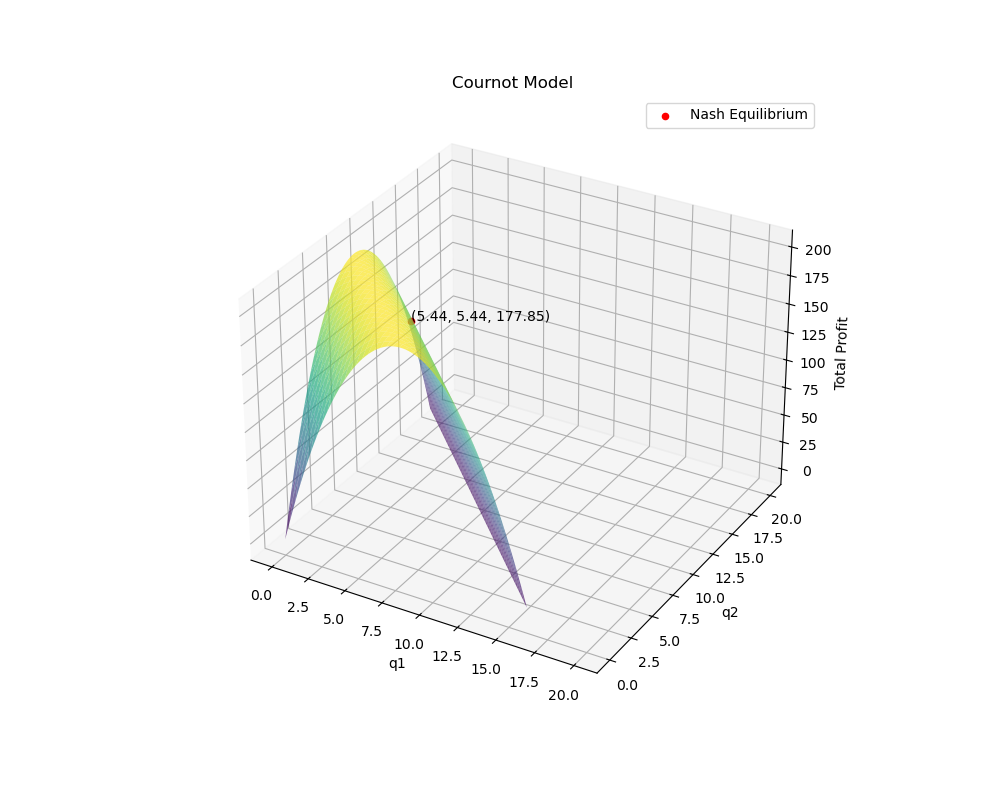

In [38]:
a_val = 50
b_val = 3
mc_duo_val = 1

plot_profit_duo(a_val, b_val, mc_duo_val)

%matplotlib widget

# Further analysis

The Cournot model can be extended to "n" firms. For our project, we will concentrate on the case involving three firms in the market, forming an oligopoly (n=3). Additionally, we will make one more extention to the model by making the marginal cost a function of the quantity produced by each firm.

Here's the modified Cournot model:

**The model**

$$
\begin{aligned}
\pi_i(q_1,....,q_n) & =q_iP \left( \sum_{j=1}^{n}q_j\right)-MC_i(q_i) \\

\end{aligned}
$$
  

**Adding another firm - From duopoly to oligopoly**

We start by adapting the model to a oligopoly scenario by adding a profit function and a best response function for Firm 3. This alters the profit functions for Firm 1 and 2, as they now have to take into account the quantity produced by Firm 3. This also effects the best response functions of the three firms as we see below and also the H-function. However, aside from this, the method is the same as used in the numerical solution with the duopol above. The code can be found in the py-file.

In [39]:
# We set the parameters as we have done previously to see the effect of adding another firm to the market
a = 50
b = 3
mc_oligo = 1

# We call the function from our py-file.
q1_star_oligo, q2_star_oligo, q3_star_oligo, total_output_oligo = nash_eq_oligo(a, b, mc_oligo)

Nash Equilibrium for mc1 = mc2 = mc3 = 1
q1* = 4.083
q2* = 4.083
q3* = 4.083
For mc = 1, the total output in an oligopoly with three firms is: 12.250


We see, that the additional firm decreases the equilibrium quantity produced by each firm. This makes sense, as another firm now contribute to the total quantity produced thus increasing the competition on the market. However, the total quantity produced increases (from 10,889 found above). We will elaborate more on this in the conclusion.

**Oligopoly with individual marginal costs**

Next up we want to add to the analysis the effects of marginal costs positively related to the individual quantities produced by the firms. We thus add the following functions to the model:

$$
\begin{aligned}
\ mc_1(q_1) = 1.1 + 3q_1 \
\end{aligned}
$$
$$
\begin{aligned}
\ mc_2(q_2) = 5 + 3q_2 \
\end{aligned}
$$
$$
\begin{aligned}
\ mc_3(q_3) = 1.1 + 1.5q_3 \
\end{aligned}
$$

In case you want to see the results for different individual marginal costs, the code can be altered in the py-file.

For the optimization problem, we use the nelder-mead method. We have tried with a few other methods, but found that the Nelder-Mead gave the best result, as the bounds provided in the problem ensure that the solution remains within feasible regions (non-negative quantities for production). In this case, the lower bound of 0 ensures that negative quantities are not considered as solutions.

In [40]:
# We use the same parameters as previously (a = 50 and b = 3), for comparability reasons, but they can be set differently here
a = 50
b = 3

# We call the function from our py-file.
q1_star_mc_var, q2_star_mc_var, q3_star_mc_var, total_output_mc_var = nash_eq_mc_var(a, b)

Nash Equilibrium:
q1* = 3.257
q2* = 2.607
q3* = 3.921
In an oligopoly with firm individual and variable MC, the total output is: 9.785


We see, that marginal costs for each firm that initially larger than 1 result in less output for each firm as we would expect. Looking closer at the firms, we see:
* a larger initial marginal cost result in a smaller output for companies with the same increase in mc per quantity of output (comparing firm 1 and 2).
* a relatively smaller increase in mc per quantity of output can have a significant effect on the overall output, as mc is kept low (comparing firm 1 and 3).

# Conclusion

Nash Equilibrium for mc1 = mc2 = 1
q1* = 5.444
q2* = 5.444
Total Output = 10.889
Nash Equilibrium for mc1 = mc2 = mc3 = 1
q1* = 4.083
q2* = 4.083
q3* = 4.083
For mc = 1, the total output in an oligopoly with three firms is: 12.250
Nash Equilibrium:
q1* = 3.257
q2* = 2.607
q3* = 3.921
In an oligopoly with firm individual and variable MC, the total output is: 9.785


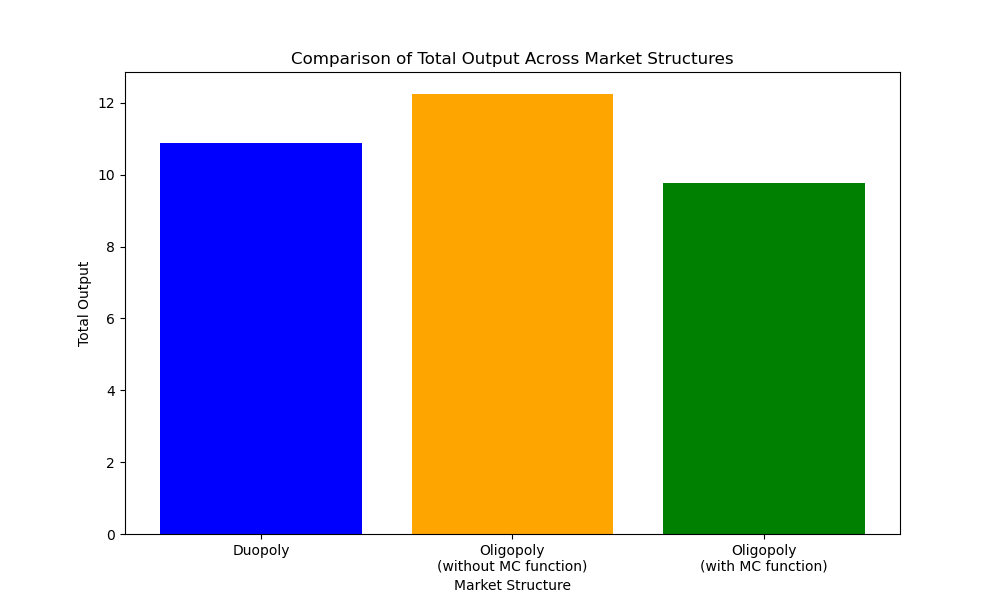

In [42]:
# again we set the parameters
a = 50
b = 3
mc_duo = 1
mc_oligo = 1

# We call the function from our py-file
plot_results(a, b, mc_duo, mc_oligo)

%matplotlib widget

The bar plot illustrates the total output across various market structures: duopoly (n=2), oligopoly (n=3) without the marginal cost function, and oligopoly (n=3) with the marginal cost function.

+ In the duopoly case, where only two firms compete, the total output is moderate compered to the other two, reflecting the balance of competition between the two firms.

+ In contrast, the total output significantly increases in the oligopoly cases, where three firms compete. This indicates that while the addition of a third firm enhances competition and output, the individual output for each firm is slighly lower compered to the duopoly case.

+ Interestingly, when incorporating the marginal cost function in the oligopoly case, the total output further decreases, falling below both the duopoly and oligopoly cases without the marginal cost function. This highlights the importance of considering the marginal cost dynamics in modeling oligopolistic competition, as firms adjust their production levels based on cost considerations. However, the decrease in total output are of course also due to the individual MC being set relatively higher than in the first part of the analysis, ehere mc were set to 1 for aech firm.

In summary, the figure demonstrates how different market structures and the incorporation of marginal cost dynamics can impact the total output in an industry. Understanding these dynamics is crucial for analyzing market behavior and making informed policy decisions.

**Acknowledging the Stackelberg Model Extension**

We could have expanded our analysis to include the Stackelberg model, where one firm acts as a leader and sets both price and quantity, while the other firm, the follower, adjusts its output accordingly. In this model, the leader typically enjoys higher profits, benefiting from its first-mover advantage. However, the follower may experience reduced profits due to the competitive response required. This extension would have provided insights into leadership dynamics and their impact on profitability in oligopolistic markets